# Lower limits of detection of Malaria Parasites in dried blood spots when using Mid-Infrared Spectroscopy and Machine Learning approaches in presence and absence of anemia 


*This notebook contains the code for evaluating the LLOD of malaria parasite in DBS using IR-ML, it has only considered non-enemic samples*

* The data has been generated from Bagamoyo culture facility from 2021-2023. 
* It contains all MIR wave numbers from the data.

###  Mshani issa ##



##  Importing all useful Libraries for our analyis ##

In [1]:
#Import impontant modules

import numpy as np 
import pandas as pd  
import scipy.stats as stats

from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import KFold

#Import ML classifiers
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier

import os
import ast
import itertools
import collections
from time import time
from tqdm import tqdm 
import collections
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import accuracy_score,f1_score, precision_score,recall_score, classification_report, confusion_matrix, precision_recall_fscore_support, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting

# Prediction on validation set

### Now import different parasitimea as binary class for validation

### Here at separate anemic condition 
* Start with 6%vs0%
* then  0.1%vs0%
* then  0.002%vs0%
* lastly 0.00003%vs0%

## Start at 50% Hematoctrits (No_Anemia)

We will load only validation set for 50% hematocrits, remember we kept 30% of this data for validation  

In [2]:
Validation_50HM_Parasitemias=pd.read_csv('No_Anemia_50%_Final_validation.csv') # Loading validation data
Validation_50HM_Parasitemias

,Unnamed: 0,Cat5,3855,3853,3851,3849,3847,3845,3843,3841,...,545,543,541,539,537,535,533,531,529,527
0,91,6PRS,0.0147,0.0147,0.0146,0.0146,0.0146,0.0147,0.0148,0.0148,...,0.1207,0.1215,0.1242,0.1243,0.1229,0.1251,0.1312,0.1361,0.1366,0.1342
1,185,0PRS,0.0156,0.0157,0.0138,0.0127,0.0132,0.0139,0.0142,0.0145,...,0.1295,0.1368,0.1425,0.1387,0.1274,0.1222,0.1321,0.1496,0.1605,0.1594
2,1,0PRS,0.0127,0.0124,0.0124,0.0125,0.0127,0.0126,0.0125,0.0124,...,0.1088,0.1055,0.1067,0.1086,0.1089,0.1094,0.1104,0.1116,0.1140,0.1172
3,67,6PRS,0.0145,0.0141,0.0138,0.0140,0.0145,0.0147,0.0147,0.0146,...,0.1433,0.1397,0.1352,0.1310,0.1281,0.1278,0.1292,0.1297,0.1301,0.1321
4,63,0.1PRS,0.0158,0.0156,0.0158,0.0162,0.0164,0.0163,0.0161,0.0160,...,0.1500,0.1451,0.1354,0.1306,0.1355,0.1427,0.1412,0.1318,0.1280,0.1358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,1492,6PRS,0.0148,0.0152,0.0132,0.0119,0.0120,0.0126,0.0131,0.0137,...,0.1083,0.1031,0.1034,0.1089,0.1124,0.1109,0.1087,0.1095,0.1117,0.1103
492,34,0.00003PRS,0.0130,0.0128,0.0126,0.0127,0.0129,0.0131,0.0132,0.0131,...,0.1169,0.1199,0.1228,0.1220,0.1191,0.1175,0.1191,0.1238,0.1293,0.1339
493,540,0.1PRS,0.0144,0.0144,0.0147,0.0149,0.0149,0.0147,0.0145,0.0143,...,0.1267,0.1244,0.1226,0.1205,0.1194,0.1209,0.1251,0.1301,0.1336,0.1379
494,1138,6PRS,0.0144,0.0145,0.0146,0.0144,0.0143,0.0142,0.0141,0.0139,...,0.1244,0.1191,0.1188,0.1227,0.1255,0.1222,0.1153,0.1114,0.1132,0.1155


###  Here we start with highest parasitemia of positive malaria at 6% against negative malaria 0% 

In [3]:
validation50 = Validation_50HM_Parasitemias[(Validation_50HM_Parasitemias["Cat5"] == '6PRS') | (Validation_50HM_Parasitemias["Cat5"] == '0PRS')]
grouped_df2 = validation50.groupby(['Cat5']).size().reset_index(name="Count") # Group by Hematocrits & Parasitemia
grouped_df2

,Cat5,Count
0,0PRS,82
1,6PRS,101


In [4]:
validation50["Cat5"]=validation50["Cat5"].replace({'6PRS': 'Positive', '0PRS': 'Negative'})
validation50

<ipython-input-4-8e409641a331>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation50["Cat5"]=validation50["Cat5"].replace({'6PRS': 'Positive', '0PRS': 'Negative'})


,Unnamed: 0,Cat5,3855,3853,3851,3849,3847,3845,3843,3841,...,545,543,541,539,537,535,533,531,529,527
0,91,Positive,0.0147,0.0147,0.0146,0.0146,0.0146,0.0147,0.0148,0.0148,...,0.1207,0.1215,0.1242,0.1243,0.1229,0.1251,0.1312,0.1361,0.1366,0.1342
1,185,Negative,0.0156,0.0157,0.0138,0.0127,0.0132,0.0139,0.0142,0.0145,...,0.1295,0.1368,0.1425,0.1387,0.1274,0.1222,0.1321,0.1496,0.1605,0.1594
2,1,Negative,0.0127,0.0124,0.0124,0.0125,0.0127,0.0126,0.0125,0.0124,...,0.1088,0.1055,0.1067,0.1086,0.1089,0.1094,0.1104,0.1116,0.1140,0.1172
3,67,Positive,0.0145,0.0141,0.0138,0.0140,0.0145,0.0147,0.0147,0.0146,...,0.1433,0.1397,0.1352,0.1310,0.1281,0.1278,0.1292,0.1297,0.1301,0.1321
5,743,Negative,0.0143,0.0142,0.0143,0.0144,0.0144,0.0145,0.0146,0.0147,...,0.1149,0.1179,0.1200,0.1197,0.1188,0.1195,0.1226,0.1280,0.1332,0.1332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,1283,Positive,0.0155,0.0154,0.0149,0.0146,0.0146,0.0147,0.0149,0.0151,...,0.1338,0.1378,0.1391,0.1358,0.1298,0.1268,0.1300,0.1364,0.1400,0.1369
488,396,Positive,0.0165,0.0164,0.0165,0.0167,0.0170,0.0171,0.0171,0.0170,...,0.1538,0.1475,0.1442,0.1446,0.1452,0.1431,0.1381,0.1329,0.1347,0.1451
489,1548,Positive,0.0115,0.0108,0.0126,0.0139,0.0138,0.0133,0.0132,0.0130,...,0.1119,0.1150,0.1152,0.1106,0.1037,0.0995,0.0999,0.1039,0.1104,0.1185
491,1492,Positive,0.0148,0.0152,0.0132,0.0119,0.0120,0.0126,0.0131,0.0137,...,0.1083,0.1031,0.1034,0.1089,0.1124,0.1109,0.1087,0.1095,0.1117,0.1103


In [5]:
# Select targets and features
X = validation50.iloc[:,2:]
Y = validation50["Cat5"]
Y

0      Positive
1      Negative
2      Negative
3      Positive
5      Negative
         ...   
484    Positive
488    Positive
489    Positive
491    Positive
494    Positive
Name: Cat5, Length: 183, dtype: object

In [6]:
usp = RandomUnderSampler(random_state = None) # balancing classes by rondom undersampling technique
X_rus, y_rus = usp.fit_sample(X, Y)
y_rus_count = collections.Counter(y_rus)
print(y_rus_count)

Counter({'Negative': 82, 'Positive': 82})


In [7]:
X_rus= MinMaxScaler().fit_transform(X_rus)
X_rus

array([[0.68965517, 0.69747899, 0.5106383 , ..., 0.72972973, 0.83135135,
        0.8598234 ],
       [0.43965517, 0.42016807, 0.36170213, ..., 0.31891892, 0.32864865,
        0.39403974],
       [0.57758621, 0.57142857, 0.56382979, ..., 0.49621622, 0.53621622,
        0.57064018],
       ...,
       [0.60344828, 0.58823529, 0.55319149, ..., 0.57621622, 0.49945946,
        0.52980132],
       [0.51724138, 0.51260504, 0.45744681, ..., 0.47027027, 0.43459459,
        0.43377483],
       [0.53448276, 0.52941176, 0.5       , ..., 0.43027027, 0.46810811,
        0.55077263]])

# We now load our classifier

In [8]:
import joblib
import pickle
# Unpickle the model from the file
with open('Malaria_classifier.pk2', 'rb') as file:
    loaded_Malaria_Classifer = pickle.load(file)

# # Specify the filename used to save the model in the first script
# model_filename = 'Model_01_With_Few_wave_numbers_.joblib'

# # Load the model
# loaded_Malaria_Classifer = joblib.load(model_filename)

In [9]:
# Predict with best classifier
Y_val_pred = loaded_Malaria_Classifer.predict(X_rus)

In [10]:
# accuracy of our classifier to the validation set 50% hematocrits
accuracy = accuracy_score(y_rus, Y_val_pred) 
print("Accuracy:%.2f%%" %(accuracy * 100.0))

Accuracy:100.00%


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
Model accuracy is reported on the test set. 10 bootstrapped samples Median accuracy is 1.00 with a 95% a confidence interval of [1.00,1.00].


C:\Users\Issa Mshani\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


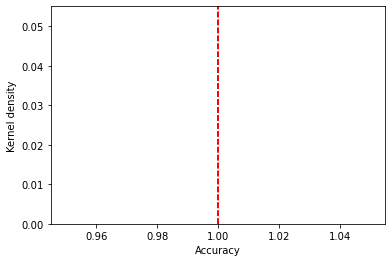

In [11]:
n_bootstrap_samples = 100

# Initialize an array to store the validation scores for each bootstrap sample
validation_scores = np.zeros(n_bootstrap_samples)

for i in range(n_bootstrap_samples):
    # Create a bootstrap sample from the validation data
    X_val_bootstrap, y_val_bootstrap = resample(X_rus, y_rus,random_state=None)
   
    # Make predictions using the already trained model
    y_pred = loaded_Malaria_Classifer.predict(X_val_bootstrap)

    # Evaluate the model on the bootstrap sample and store the validation score
    accuracy = accuracy_score(y_val_bootstrap, y_pred)
    validation_scores[i] = accuracy
    
print(validation_scores)

################################################
# Calculate median
median = np.percentile(validation_scores, 50)

# Calculate 95% interval
alpha = 100-95
lower_ci = np.percentile(validation_scores, alpha/2)
upper_ci = np.percentile(validation_scores, 100-alpha/2)

print(f"Model accuracy is reported on the test set. 10 bootstrapped samples " 
      f"Median accuracy is {median:.2f} with a 95% a confidence "
      f"interval of [{lower_ci:.2f},{upper_ci:.2f}].")

#################################################

sns.kdeplot(validation_scores)
plt.xlabel("Accuracy")
plt.ylabel("Kernel density")
plt.axvline(median,0, 14, linestyle="--", color="red")
plt.axvline(lower_ci,0, 14, linestyle="--", color="red")
plt.axvline(upper_ci,0, 14, linestyle="--", color="red")
plt.show()

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalise=True,
                          text=False,
                          title='Confusion matrix',color='r',
                          xrotation=0,
                          yrotation=0,
                          saturation=2,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalisation can be applied by setting 'normalise=True'.
    """

    if normalise:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "{0} (normalised)".format(title)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks([0.009,0.91], ["Positive", 'Negative'],fontsize=18)
    plt.yticks([0.008,0.81], ["Positive", 'Negative'],fontsize=18,rotation=90)

    if text:
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]),
                                      range(cm.shape[1])):
            plt.text(j, i, "{0:.2f}".format(cm[i, j]), horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', color= 'black',fontsize=20, Weight="bold")
    plt.xlabel('Predicted label', color='black',fontsize=20, Weight="bold")

Normalized confusion matrix


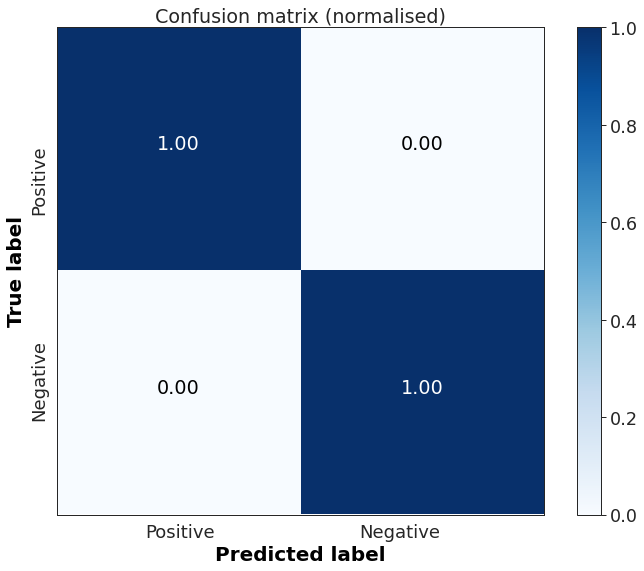

In [13]:
sns.set(context="paper", 
        style="white", 
        font_scale = 2.0,
        rc={"font.family": "Dejavu Sans"}) 
plt.rcParams["figure.figsize"] = [10,8] 
cm = confusion_matrix(y_rus, Y_val_pred) 
class_names = np.unique(np.sort(y_rus)) 
plot_confusion_matrix(cm, text=True,
                      color='black',
                      normalise=True,
                      classes=class_names) 

# Validation for parasitemia 0.1% vs 0%

In [14]:
############import the 50% dataset
Validation_50HM_Parasitemias=pd.read_csv('No_Anemia_50%_Final_validation.csv') # Loading all data
print (Validation_50HM_Parasitemias)

######################### filter respective parasitemia 
validation50 = Validation_50HM_Parasitemias[(Validation_50HM_Parasitemias["Cat5"] == '0.1PRS') | (Validation_50HM_Parasitemias["Cat5"] == '0PRS')]
grouped_df2 = validation50.groupby(['Cat5']).size().reset_index(name="Count") # Group by Hematocrits & Parasitemia
print (grouped_df2)

##### rebelling
validation50["Cat5"]=validation50["Cat5"].replace({'0.1PRS': 'Positive', '0PRS': 'Negative'})
print (validation50)

#######################

# Select targets and features
X = validation50.iloc[:,2:]
Y = validation50["Cat5"]
print(X)

#######################

# balancing classes by rondom undersampling technique
usp = RandomUnderSampler(random_state = None)
X_rus, y_rus = usp.fit_sample(X, Y)
y_rus_count = collections.Counter(y_rus)
print(y_rus_count)

######################
# Scalling
X_rus= MinMaxScaler().fit_transform(X_rus)
print(X_rus)
######################
# use best classifier to predict
Y_val_pred = loaded_Malaria_Classifer.predict(X_rus)

# Accuracy of our classifier to the validation
accuracy = accuracy_score(y_rus, Y_val_pred) 
print("Accuracy on validation 0.1PRS at 50HMT:%.2f%%" %(accuracy * 100.0))

     Unnamed: 0        Cat5    3855    3853    3851    3849    3847    3845  \
0            91        6PRS  0.0147  0.0147  0.0146  0.0146  0.0146  0.0147   
1           185        0PRS  0.0156  0.0157  0.0138  0.0127  0.0132  0.0139   
2             1        0PRS  0.0127  0.0124  0.0124  0.0125  0.0127  0.0126   
3            67        6PRS  0.0145  0.0141  0.0138  0.0140  0.0145  0.0147   
4            63      0.1PRS  0.0158  0.0156  0.0158  0.0162  0.0164  0.0163   
..          ...         ...     ...     ...     ...     ...     ...     ...   
491        1492        6PRS  0.0148  0.0152  0.0132  0.0119  0.0120  0.0126   
492          34  0.00003PRS  0.0130  0.0128  0.0126  0.0127  0.0129  0.0131   
493         540      0.1PRS  0.0144  0.0144  0.0147  0.0149  0.0149  0.0147   
494        1138        6PRS  0.0144  0.0145  0.0146  0.0144  0.0143  0.0142   
495         126    0.002PRS  0.0135  0.0133  0.0132  0.0133  0.0135  0.0136   

       3843    3841  ...     545     543     541   

<ipython-input-14-3b13651d71e6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation50["Cat5"]=validation50["Cat5"].replace({'0.1PRS': 'Positive', '0PRS': 'Negative'})


Counter({'Negative': 82, 'Positive': 82})
[[0.72519084 0.72307692 0.66964286 ... 0.72972973 0.83135135 0.8598234 ]
 [0.50381679 0.46923077 0.54464286 ... 0.31891892 0.32864865 0.39403974]
 [0.6259542  0.60769231 0.71428571 ... 0.49621622 0.53621622 0.57064018]
 ...
 [0.59541985 0.57692308 0.65178571 ... 0.43135135 0.45513514 0.43598234]
 [0.48854962 0.47692308 0.55357143 ... 0.32648649 0.3372973  0.35540839]
 [0.83969466 0.85384615 0.83035714 ... 0.7427027  0.74378378 0.77924945]]
Accuracy on validation 0.1PRS at 50HMT:100.00%


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
Model accuracy is reported on the test set. 10 bootstrapped samples Median accuracy is 1.00 with a 95% a confidence interval of [1.00,1.00].


C:\Users\Issa Mshani\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


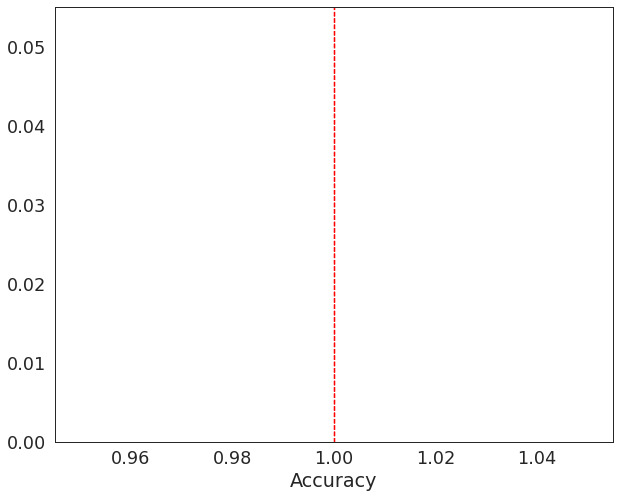

In [15]:
n_bootstrap_samples = 100

# Initialize an array to store the validation scores for each bootstrap sample
validation_scores = np.zeros(n_bootstrap_samples)

for i in range(n_bootstrap_samples):
    # Create a bootstrap sample from the validation data
    X_val_bootstrap, y_val_bootstrap = resample(X_rus, y_rus,random_state=None)
   
    # Make predictions using the already trained model
    y_pred =  loaded_Malaria_Classifer.predict(X_val_bootstrap)

    # Evaluate the model on the bootstrap sample and store the validation score
    accuracy = accuracy_score(y_val_bootstrap, y_pred)
    validation_scores[i] = accuracy
    
print(validation_scores)

################################################
# Calculate median
median = np.percentile(validation_scores, 50)

# Calculate 95% interval
alpha = 100-95
lower_ci = np.percentile(validation_scores, alpha/2)
upper_ci = np.percentile(validation_scores, 100-alpha/2)

print(f"Model accuracy is reported on the test set. 10 bootstrapped samples " 
      f"Median accuracy is {median:.2f} with a 95% a confidence "
      f"interval of [{lower_ci:.2f},{upper_ci:.2f}].")

#################################################

sns.kdeplot(validation_scores)
plt.xlabel("Accuracy")
plt.axvline(median,0, 14, linestyle="--", color="red")
plt.axvline(lower_ci,0, 14, linestyle="--", color="red")
plt.axvline(upper_ci,0, 14, linestyle="--", color="red")
plt.show()

Normalized confusion matrix


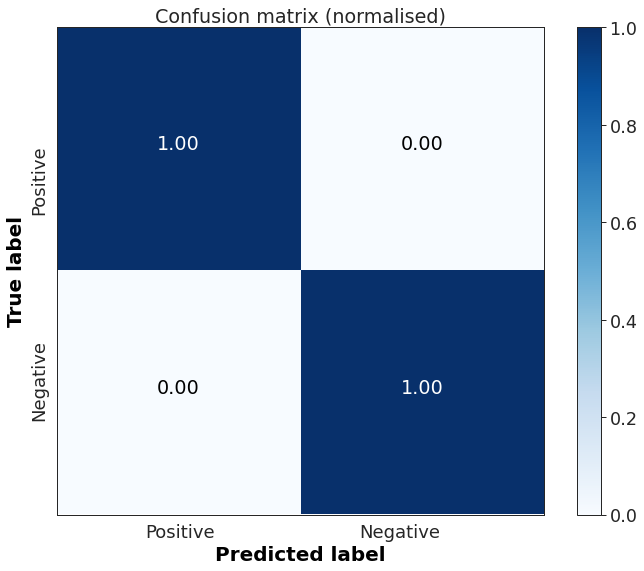

In [16]:
sns.set(context="paper", 
        style="white", 
        font_scale = 2.0,
        rc={"font.family": "Dejavu Sans"}) 
plt.rcParams["figure.figsize"] = [10,8] 
cm = confusion_matrix(y_rus, Y_val_pred) 
class_names = np.unique(np.sort(y_rus)) 
plot_confusion_matrix(cm, text=True,
                      color='black',
                      normalise=True,
                      classes=class_names)

In [17]:
# Summarising precision, f_score, and recall for the training set

cr =  classification_report(y_rus, Y_val_pred)

print(cr)

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        82
    Positive       1.00      1.00      1.00        82

    accuracy                           1.00       164
   macro avg       1.00      1.00      1.00       164
weighted avg       1.00      1.00      1.00       164



# Validation for Parasitemia 0.002% vs 0% at 50HMT

In [18]:
############import the 50% dataset
Validation_50HM_Parasitemias=pd.read_csv('No_Anemia_50%_Final_validation.csv') # Loading all data
print (Validation_50HM_Parasitemias)

######################### filter respective parasitemia 
validation50 = Validation_50HM_Parasitemias[(Validation_50HM_Parasitemias["Cat5"] == '0.002PRS') | (Validation_50HM_Parasitemias["Cat5"] == '0PRS')]
grouped_df2 = validation50.groupby(['Cat5']).size().reset_index(name="Count") # Group by Hematocrits & Parasitemia
print (grouped_df2)

##### rebelling
validation50["Cat5"]=validation50["Cat5"].replace({'0.002PRS': 'Positive', '0PRS': 'Negative'})
print (validation50)

#######################

# Select targets and features
X = validation50.iloc[:,2:]
Y = validation50["Cat5"]
print(X)

#######################

# balancing classes by rondom undersampling technique
usp = RandomUnderSampler(random_state = None)
X_rus, y_rus = usp.fit_sample(X, Y)
y_rus_count = collections.Counter(y_rus)
print(y_rus_count)

######################
# Scalling
X_rus= MinMaxScaler().fit_transform(X_rus)
print(X_rus)
######################
#best classifier for prediction
Y_val_pred = loaded_Malaria_Classifer.predict(X_rus)

# Accuracy of our classifier to the validation
accuracy = accuracy_score(y_rus, Y_val_pred) 
print("Accuracy on validation 0.002PRS at 50HMT:%.2f%%" %(accuracy * 100.0))


     Unnamed: 0        Cat5    3855    3853    3851    3849    3847    3845  \
0            91        6PRS  0.0147  0.0147  0.0146  0.0146  0.0146  0.0147   
1           185        0PRS  0.0156  0.0157  0.0138  0.0127  0.0132  0.0139   
2             1        0PRS  0.0127  0.0124  0.0124  0.0125  0.0127  0.0126   
3            67        6PRS  0.0145  0.0141  0.0138  0.0140  0.0145  0.0147   
4            63      0.1PRS  0.0158  0.0156  0.0158  0.0162  0.0164  0.0163   
..          ...         ...     ...     ...     ...     ...     ...     ...   
491        1492        6PRS  0.0148  0.0152  0.0132  0.0119  0.0120  0.0126   
492          34  0.00003PRS  0.0130  0.0128  0.0126  0.0127  0.0129  0.0131   
493         540      0.1PRS  0.0144  0.0144  0.0147  0.0149  0.0149  0.0147   
494        1138        6PRS  0.0144  0.0145  0.0146  0.0144  0.0143  0.0142   
495         126    0.002PRS  0.0135  0.0133  0.0132  0.0133  0.0135  0.0136   

       3843    3841  ...     545     543     541   

<ipython-input-18-eb4c14a78437>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation50["Cat5"]=validation50["Cat5"].replace({'0.002PRS': 'Positive', '0PRS': 'Negative'})


Counter({'Negative': 82, 'Positive': 82})
[[0.68965517 0.69747899 0.56976744 ... 0.73794549 0.84146341 0.86757039]
 [0.43965517 0.42016807 0.40697674 ... 0.33962264 0.36890244 0.42752868]
 [0.57758621 0.57142857 0.62790698 ... 0.5115304  0.56402439 0.59436913]
 ...
 [0.3362069  0.30252101 0.19767442 ... 0.14989518 0.24796748 0.32950991]
 [0.68103448 0.67226891 0.75581395 ... 0.34696017 0.34044715 0.39728884]
 [0.62931034 0.58823529 0.63953488 ... 0.55870021 0.59756098 0.67778936]]
Accuracy on validation 0.002PRS at 50HMT:91.46%


[0.91463415 0.90243902 0.8902439  0.86585366 0.93902439 0.95121951
 0.91463415 0.91463415 0.91463415 0.91463415 0.95121951 0.93292683
 0.89634146 0.8902439  0.92682927 0.94512195 0.92682927 0.93902439
 0.89634146 0.90853659 0.95731707 0.92073171 0.95731707 0.90853659
 0.92073171 0.94512195 0.91463415 0.93292683 0.93902439 0.88414634
 0.92073171 0.94512195 0.88414634 0.92073171 0.92073171 0.91463415
 0.90243902 0.91463415 0.90853659 0.93902439 0.91463415 0.93292683
 0.91463415 0.91463415 0.95121951 0.91463415 0.90243902 0.87804878
 0.93292683 0.95731707 0.92073171 0.88414634 0.93902439 0.86585366
 0.89634146 0.89634146 0.92682927 0.90243902 0.92682927 0.92073171
 0.84146341 0.88414634 0.92073171 0.93292683 0.94512195 0.87804878
 0.93902439 0.87195122 0.93292683 0.92073171 0.91463415 0.90853659
 0.90243902 0.91463415 0.92073171 0.88414634 0.94512195 0.8902439
 0.8902439  0.8902439  0.95121951 0.90243902 0.90853659 0.92073171
 0.90243902 0.89634146 0.91463415 0.92073171 0.90853659 0.91463

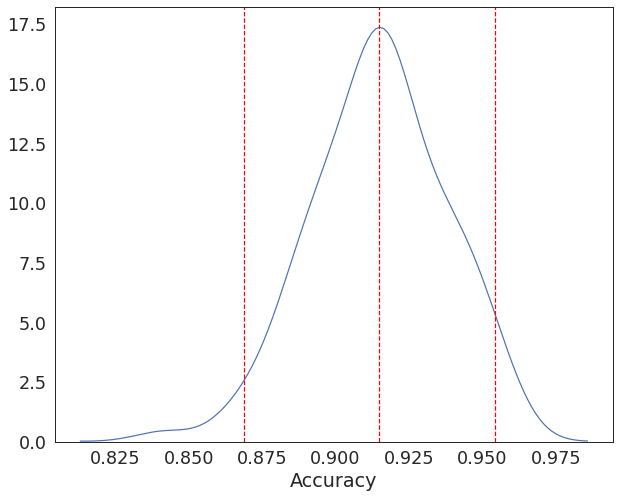

In [19]:
n_bootstrap_samples = 100

# Initialize an array to store the validation scores for each bootstrap sample
validation_scores = np.zeros(n_bootstrap_samples)

for i in range(n_bootstrap_samples):
    # Create a bootstrap sample from the validation data
    X_val_bootstrap, y_val_bootstrap = resample(X_rus, y_rus,random_state=None)
   
    # Make predictions using the already trained model
    y_pred = loaded_Malaria_Classifer.predict(X_val_bootstrap)

    # Evaluate the model on the bootstrap sample and store the validation score
    accuracy = accuracy_score(y_val_bootstrap, y_pred)
    validation_scores[i] = accuracy
    
print(validation_scores)

################################################
# Calculate median
median = np.percentile(validation_scores, 50)

# Calculate 95% interval
alpha = 100-95
lower_ci = np.percentile(validation_scores, alpha/2)
upper_ci = np.percentile(validation_scores, 100-alpha/2)

print(f"Model accuracy is reported on the test set. 10 bootstrapped samples " 
      f"Median accuracy is {median:.2f} with a 95% a confidence "
      f"interval of [{lower_ci:.2f},{upper_ci:.2f}].")

#################################################
sns.kdeplot(validation_scores)
plt.xlabel("Accuracy")
plt.axvline(median,0, 14, linestyle="--", color="red")
plt.axvline(lower_ci,0, 14, linestyle="--", color="red")
plt.axvline(upper_ci,0, 14, linestyle="--", color="red")
plt.show()


Normalized confusion matrix


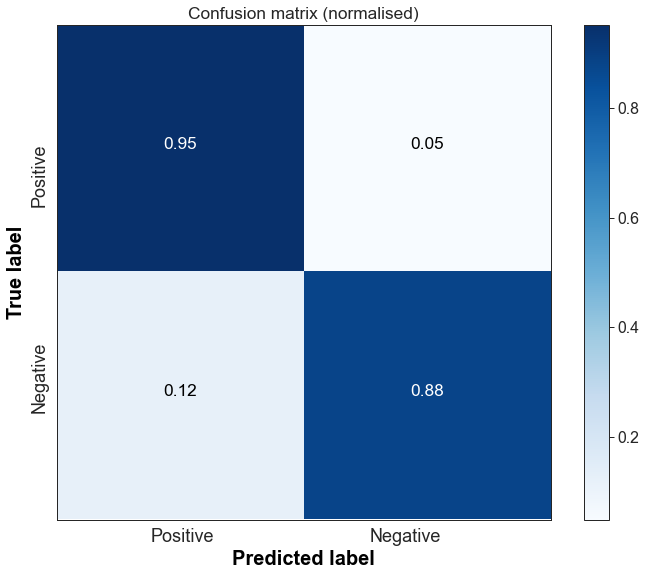

In [20]:
plt.rcParams["figure.figsize"] = [10,8] 
cm = confusion_matrix(y_rus, Y_val_pred) 
class_names = np.unique(np.sort(y_rus)) 
plot_confusion_matrix(cm, text=True,
                      color='black',
                      normalise=True,
                      classes=class_names) 

In [21]:
# Summarising precision, f_score, and recall for the training set

cr =  classification_report(y_rus, Y_val_pred)

print(cr)

              precision    recall  f1-score   support

    Negative       0.89      0.95      0.92        82
    Positive       0.95      0.88      0.91        82

    accuracy                           0.91       164
   macro avg       0.92      0.91      0.91       164
weighted avg       0.92      0.91      0.91       164



# Validation for Parasitemia 0.00003% vs 0% at 50HMT

In [22]:
############import the 50% dataset
Validation_50HM_Parasitemias=pd.read_csv('No_Anemia_50%_Final_validation.csv') # Loading all data
print (Validation_50HM_Parasitemias)

######################### filter respective parasitemia 
validation50 = Validation_50HM_Parasitemias[(Validation_50HM_Parasitemias["Cat5"] == '0.00003PRS') | (Validation_50HM_Parasitemias["Cat5"] == '0PRS')]
grouped_df2 = validation50.groupby(['Cat5']).size().reset_index(name="Count") # Group by Hematocrits & Parasitemia
print (grouped_df2)

##### rebelling
validation50["Cat5"]=validation50["Cat5"].replace({'0.00003PRS': 'Positive', '0PRS': 'Negative'})
print (validation50)

#######################

# Select targets and features
X = validation50.iloc[:,2:]
Y = validation50["Cat5"]
print(X)

#######################

# # balancing classes by rondom undersampling technique
usp = RandomUnderSampler(random_state = None)
X_rus, y_rus = usp.fit_sample(X, Y)
y_rus_count = collections.Counter(y_rus)
print(y_rus_count)

#######################
Scalling
X_rus= MinMaxScaler().fit_transform(X_rus)
print(X_rus)
#########Best classifier predictions ######################
Y_val_pred = loaded_Malaria_Classifer.predict(X_rus)

# Accuracy of our classifier to the validation
accuracy = accuracy_score(y_rus, Y_val_pred) 
print("Accuracy on validation 0.002PRS at 50HMT:%.2f%%" %(accuracy * 100.0))

     Unnamed: 0        Cat5    3855    3853    3851    3849    3847    3845  \
0            91        6PRS  0.0147  0.0147  0.0146  0.0146  0.0146  0.0147   
1           185        0PRS  0.0156  0.0157  0.0138  0.0127  0.0132  0.0139   
2             1        0PRS  0.0127  0.0124  0.0124  0.0125  0.0127  0.0126   
3            67        6PRS  0.0145  0.0141  0.0138  0.0140  0.0145  0.0147   
4            63      0.1PRS  0.0158  0.0156  0.0158  0.0162  0.0164  0.0163   
..          ...         ...     ...     ...     ...     ...     ...     ...   
491        1492        6PRS  0.0148  0.0152  0.0132  0.0119  0.0120  0.0126   
492          34  0.00003PRS  0.0130  0.0128  0.0126  0.0127  0.0129  0.0131   
493         540      0.1PRS  0.0144  0.0144  0.0147  0.0149  0.0149  0.0147   
494        1138        6PRS  0.0144  0.0145  0.0146  0.0144  0.0143  0.0142   
495         126    0.002PRS  0.0135  0.0133  0.0132  0.0133  0.0135  0.0136   

       3843    3841  ...     545     543     541   

<ipython-input-22-4b484af5e09b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation50["Cat5"]=validation50["Cat5"].replace({'0.00003PRS': 'Positive', '0PRS': 'Negative'})


Counter({'Negative': 82, 'Positive': 82})
Accuracy on validation 0.002PRS at 50HMT:92.07%


[0.88414634 0.92682927 0.98170732 0.93902439 0.94512195 0.93292683
 0.94512195 0.92073171 0.93902439 0.91463415 0.90853659 0.91463415
 0.92682927 0.90243902 0.92682927 0.94512195 0.92682927 0.93292683
 0.92073171 0.93902439 0.94512195 0.93292683 0.92682927 0.90243902
 0.90243902 0.92682927 0.94512195 0.95731707 0.95121951 0.92682927
 0.92073171 0.92073171 0.87804878 0.92682927 0.8902439  0.95731707
 0.90853659 0.93292683 0.93292683 0.90853659 0.93902439 0.92073171
 0.90853659 0.95731707 0.91463415 0.90853659 0.90853659 0.93292683
 0.88414634 0.92682927 0.94512195 0.92073171 0.92073171 0.92073171
 0.91463415 0.89634146 0.95121951 0.92682927 0.92073171 0.90243902
 0.94512195 0.93902439 0.90243902 0.92073171 0.8902439  0.93902439
 0.89634146 0.89634146 0.8902439  0.91463415 0.90853659 0.92682927
 0.90853659 0.90243902 0.91463415 0.92682927 0.91463415 0.93292683
 0.92682927 0.94512195 0.92682927 0.93292683 0.8902439  0.93292683
 0.88414634 0.92073171 0.92073171 0.92682927 0.92682927 0.9024

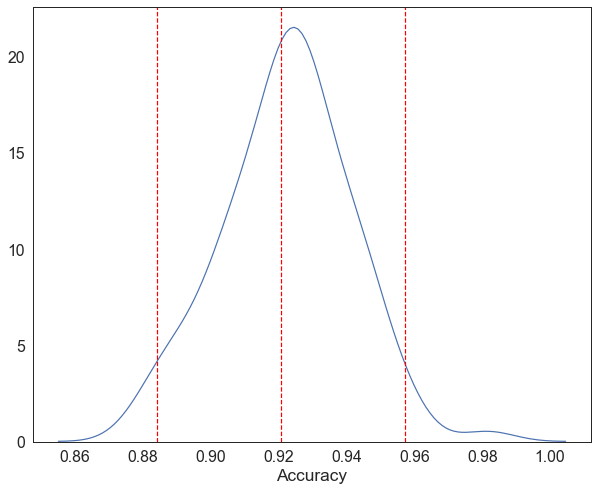

In [23]:
n_bootstrap_samples = 100

# Initialize an array to store the validation scores for each bootstrap sample
validation_scores = np.zeros(n_bootstrap_samples)

for i in range(n_bootstrap_samples):
    # Create a bootstrap sample from the validation data
    X_val_bootstrap, y_val_bootstrap = resample(X_rus, y_rus,random_state=None)
   
    # Make predictions using the best classifier
    y_pred = loaded_Malaria_Classifer.predict(X_val_bootstrap)

    # Evaluate the model on the bootstrap sample and store the validation score
    accuracy = accuracy_score(y_val_bootstrap, y_pred)
    validation_scores[i] = accuracy
    
print(validation_scores)

################################################
# median
median = np.percentile(validation_scores, 50)

# 95% interval
alpha = 100-95
lower_ci = np.percentile(validation_scores, alpha/2)
upper_ci = np.percentile(validation_scores, 100-alpha/2)

print(f"Model accuracy is reported on the test set. 10 bootstrapped samples " 
      f"Median accuracy is {median:.2f} with a 95% a confidence "
      f"interval of [{lower_ci:.2f},{upper_ci:.2f}].")

#################################################

sns.kdeplot(validation_scores)
plt.xlabel("Accuracy")
plt.axvline(median,0, 14, linestyle="--", color="red")
plt.axvline(lower_ci,0, 14, linestyle="--", color="red")
plt.axvline(upper_ci,0, 14, linestyle="--", color="red")
plt.show()


Normalized confusion matrix


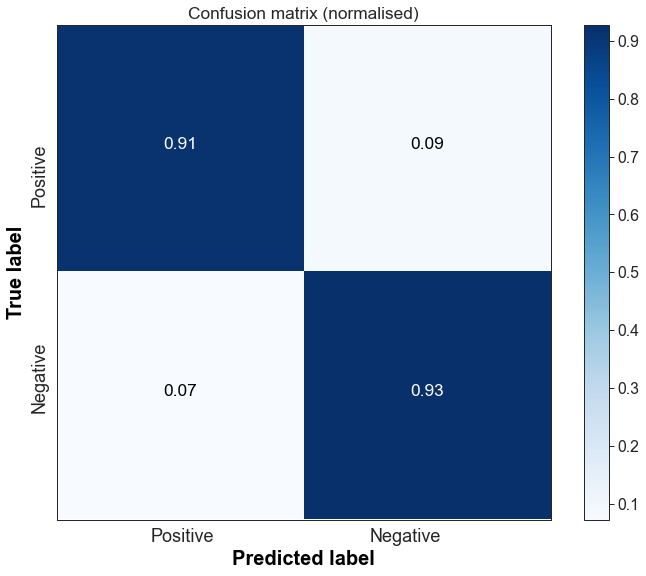

In [24]:
plt.rcParams["figure.figsize"] = [10,8] 
cm = confusion_matrix(y_rus, Y_val_pred) 
class_names = np.unique(np.sort(y_rus)) 
plot_confusion_matrix(cm, text=True,
                      color='black',
                      normalise=True,
                      classes=class_names) 
#plt.savefig("validation_Field_DE.png", dpi = 300, bbox_inches="tight")

In [25]:
# Summarising precision, f_score, and recall for the training set

cr =  classification_report(y_rus, Y_val_pred)

print(cr)

              precision    recall  f1-score   support

    Negative       0.93      0.91      0.92        82
    Positive       0.92      0.93      0.92        82

    accuracy                           0.92       164
   macro avg       0.92      0.92      0.92       164
weighted avg       0.92      0.92      0.92       164

